In [138]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
import numpy as np


def load_csv(filePath, sep=','):
    return pd.read_csv(filePath, sep=sep)

def engineer_features(df):
    df = df.copy()
    # Age in years
    df['age_years'] = df['age'] // 365
    # BMI
    df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
    # Pulse pressure
    df['pulse_pressure'] = df['bp_high'] - df['bp_low']
    # Hypertension flag
    df['is_hypertensive'] = ((df['bp_high'] >= 140) | (df['bp_low'] >= 90)).astype(int)
    # Combined metabolic risk
    df['risk_level'] = df['cholesterol'] + df['glucose_level']
    # Drop raw columns used to create features
    df.drop(columns=[
        'age', 'height', 'weight', 'bp_high', 'bp_low', 'cholesterol', 'glucose_level'
    ], inplace=True)
    return df

def split_features_target(df, yColumn, dropColumns):
    X = df.drop(columns=dropColumns + [yColumn])
    y = df[yColumn]
    return X, y

def apply_polynomial(X, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    columns = poly.get_feature_names_out(X.columns if isinstance(X, pd.DataFrame) else None)
    return pd.DataFrame(X_poly, columns=columns)

def apply_scaling(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns=X.columns)

def split_data(X, y, test_size=0.4, cv_size=0.5, seed=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=cv_size, random_state=seed)
    return X_train, y_train, X_cv, y_cv, X_test, y_test

def prepare_data(filePath, 
                 yColumn, 
                 csv_sep=',',
                 scale=True,
                 polynomial=False,
                 polyDegree=2,
                 dropColumns=['id']):

    df = load_csv(filePath, sep=csv_sep)

    # Apply feature engineering
    # df = engineer_features(df)

    # Drop duplicate drops (prevent appending yColumn every call)
    dropCols = list(dropColumns)  # copy list to avoid side effects
    if yColumn not in dropCols:
        dropCols.append(yColumn)

    X, y = split_features_target(df, yColumn, dropCols)

    if polynomial:
        X = apply_polynomial(X, degree=polyDegree)

    if scale:
        X = apply_scaling(X)

    return split_data(X, y)


def train_model(X, y, w=None, epochs = 100):
    model = SGDRegressor(max_iter=epochs, learning_rate='constant', eta0=0.001, random_state=42)
    model.fit(X,y, w)

    print('Max Iterations:', epochs)
    print('Total Iterations',model.n_iter_)
    print('Training Score: ',model.score(X, y))

    return model


def predict_plot(model, X, y, plottingSample = None, predictionLine=True, dotsWithPridction=False):
    y_hats = model.predict(X)

    mse = mean_squared_error(y, y_hats)
    r2 = r2_score(y, y_hats)

    print("MSE:", mse)
    print("R² score:", r2)
    
    if(plottingSample == None):
        plottingSample = len(y_hats)

    plt.scatter(range(plottingSample), y[:plottingSample], label='True Y')
    if dotsWithPridction:
        plt.scatter(range(plottingSample), y_hats[:plottingSample],color='red' )
    if predictionLine:
        plt.plot(range(plottingSample), y_hats[:plottingSample], label='Predicted Y (Line)', color='green')
        
    plt.title('Prediction vs True Values')
    plt.xlabel('Index')
    plt.ylabel('Y Value')
    # plt.legend()
    plt.show()

def combine_datasets(X1, y1, X2, y2):
     X = np.concatenate((X1, X2), axis=0)
     y = np.concatenate((y1, y2), axis=0)
     
     return X,y


In [136]:
dsPath = '../data/unzipped-data/house_pricing_100k.csv'
yColumn  = 'Price'

X_train, y_train, X_cv, y_cv, X_test, y_test = prepare_data(dsPath,
                                                            yColumn,
                                                            dropColumns=['House_ID'],
                                                            polynomial=True,
                                                            polyDegree=1)
X = X_train
y = y_train
# X, y = combine_datasets(X, y, X_test, y_test)
# X, y = combine_datasets(X, y, X_cv, y_cv)

model = train_model(X, y ,epochs=200000)
# print(X_train.shape)
# print(y_train.shape)

# print(X_cv.shape)
# print(y_cv.shape)

# print(X_test.shape)
# print(y_test.shape)

# 0.9999986180518786 - d1
# 0.9999667204672764 - d2
# 0.999931162952842 - d3

Max Iterations: 200000
Total Iterations 13
Training Score:  0.9999986180518786


MSE: 13246.911783984488
R² score: 0.9999986180518786


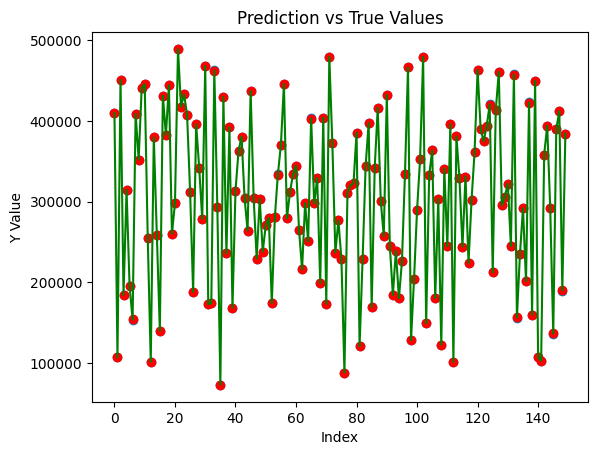

MSE: 13134.64493965513
R² score: 0.999998616904064


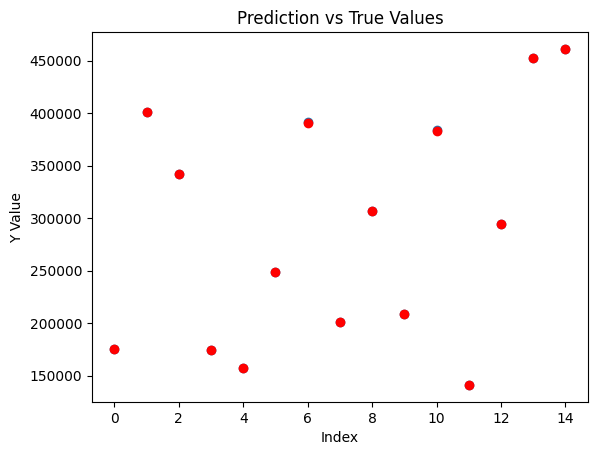

MSE: 13285.779470619951
R² score: 0.9999986191872025


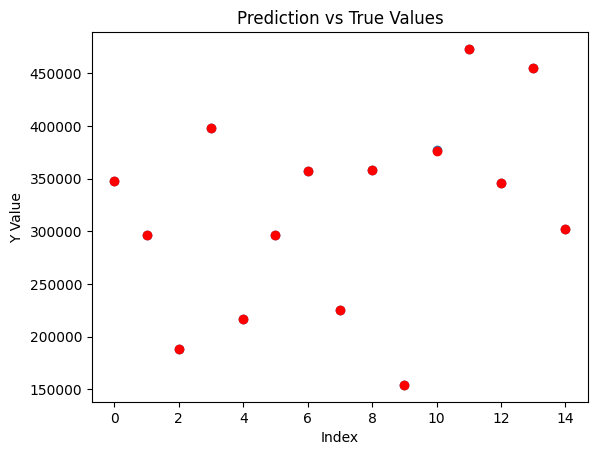

In [145]:

# X_combined_test = np.concatenate((X_cv, X_test), axis=0)
# y_combined_test = np.concatenate((y_cv, y_test), axis=0)

# X_combined_test = np.concatenate((X_combined_test, X_train), axis=0)
# y_combined_test = np.concatenate((y_combined_test, y_train), axis=0)

predict_plot(model, X_train, y_train, predictionLine=True, dotsWithPridction=True,plottingSample=150)
predict_plot(model, X_cv, y_cv, predictionLine=False,dotsWithPridction=True,plottingSample=15)
predict_plot(model, X_test, y_test, predictionLine=False,dotsWithPridction=True,plottingSample=15)

# Training DS
# 0.9832133833477126 - d1
# 0.9971082943214111 - d2
# 0.997754746244004 - d3 - Largest
# 0.9708896002443996 - d4

# Combined DS
# 0.9879661457288624 - d1
# 0.9952844590862006 - d2
# 0.9952302558352341 d3
# 0.9935214591980353 d4

# Full Data
# 
